In [1]:
#!pip install tensorflow

In [2]:
import psycopg2
import pandas as pd
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from keras.models import Sequential,load_model
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.utils import resample
from imblearn.over_sampling import ADASYN
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Dense, Dropout,Flatten,LeakyReLU,Conv1D,MaxPooling1D, Activation,SpatialDropout1D,GlobalAveragePooling1D,BatchNormalization
from keras.models import model_from_json
import tensorflow as tf
from keras.callbacks import EarlyStopping

2023-11-22 13:45:00.004859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 13:45:01.260256: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-22 13:45:01.260362: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-22 13:45:01.260370: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
conn=psycopg2.connect(database='mimiciv',user='hyu',password='qlrqod123',host='127.0.0.1',port='5432')
print('Open successfully')
cursor=conn.cursor()

Open successfully


In [4]:
patient=pd.read_sql_query('select distinct on (patient.subject_id) patient.subject_id,gender,anchor_age, ethnicity,icd_code from mimiciv.admission inner join mimiciv.patient on admission.subject_id=patient.subject_id inner join mimiciv.diagnoses_icd on diagnoses_icd.subject_id=patient.subject_id order by patient.subject_id',conn)
patient.drop(patient[(patient.anchor_age==0)].index,axis=0,inplace=True)
patient.reset_index(drop=True,inplace=True)
print(patient.shape)

(194275, 5)


In [5]:
icd_code=pd.read_sql_query("select distinct on(subject_id) subject_id,icd_code from mimiciv.diagnoses_icd where icd_code like '%O10%'or icd_code like '%O11%' or icd_code like '%O12%' or icd_code like '%O13%' or icd_code like '%O14%' or icd_code like '%O15%'or icd_code like '%O16%' or icd_code like '%I15%' or icd_code like '405%' or icd_code like '642%' order by subject_id",conn)
print(len(icd_code))

2926


In [6]:
ids=list(icd_code['subject_id'])
for i in ids:
    patient.loc[(patient.subject_id==i),'icd_code']='1'

In [7]:
patient.icd_code.value_counts()

4019       5416
1          2922
2724       2693
I10        2483
30500      2120
           ... 
C7A020        1
O411220       1
V0300XA       1
95200         1
7513          1
Name: icd_code, Length: 11026, dtype: int64

In [8]:
chartevent=pd.read_sql_query('select subject_id,charttime,itemid,value,valueuom from mimiciv.chartevents where itemid=226730 or itemid=226512 or itemid=220621 order by subject_id,itemid,charttime',conn)
chartevent['value']=pd.to_numeric(chartevent['value'],errors='coerce')
chartevent.drop_duplicates(['subject_id','itemid'],keep='first',inplace=True)
chartevent.reset_index(drop=True,inplace=True)
chartfeatures=chartevent.pivot(index='subject_id',columns='itemid',values='value')
chartfeatures.reset_index(inplace=True)
chartfeatures_fillna=chartfeatures.fillna(chartfeatures.mean())
print(chartfeatures_fillna.shape)

(53129, 4)


In [9]:
chartfeatures_fillna.columns=['subject_id','glucose','weight','height']
df_new=patient.merge(chartfeatures_fillna)
df_new.rename(columns={'anchor_age':'age'},inplace=True)
df_new.loc[df_new['icd_code']!='1','icd_code']=0
df_new.icd_code.value_counts()

0    52810
1      303
Name: icd_code, dtype: int64

In [10]:
df_new.drop('subject_id',axis=1,inplace=True)
df_new.drop(df_new[df_new.glucose>1000].index,axis=0,inplace=True)
df_new.drop(df_new[df_new.weight>200].index,axis=0,inplace=True)
df_new.drop(df_new[df_new.height>200].index,axis=0,inplace=True)

df_new.reset_index(drop=True,inplace=True)
df_new.shape

(52931, 7)

In [11]:
df_new.drop(df_new[df_new.height==0].index,axis=0,inplace=True)
df_new.reset_index(drop=True,inplace=True)
df_new['BMI']=round(df_new['weight']/((df_new['height']/100)**2),2)
df_new.drop(df_new[df_new['BMI']>100].index,axis=0,inplace=True)
df_new.reset_index(drop=True,inplace=True)

df_new=df_new[['age','gender','glucose','weight','height','BMI','icd_code']]
df_new

,age,gender,glucose,weight,height,BMI,icd_code
0,52,F,115.000000,39.4,152.000000,17.05,0
1,73,F,411.396465,76.2,168.824223,26.74,0
2,55,F,113.000000,71.2,168.824223,24.98,0
3,46,F,146.000000,72.2,157.000000,29.29,0
4,68,F,148.000000,65.0,157.000000,26.37,0
...,...,...,...,...,...,...,...
52745,41,M,136.000000,107.5,193.000000,28.86,0
52746,81,M,175.000000,50.5,168.824223,17.72,0
52747,46,F,192.000000,67.9,168.824223,23.82,0
52748,58,M,98.000000,77.5,178.000000,24.46,0


In [12]:
df_final=df_new.copy()
gender_map={'M':0,'F':1}
df_final['gender']=df_final['gender'].map(gender_map)
df_final.icd_code=pd.to_numeric(df_final.icd_code,errors='coerce')

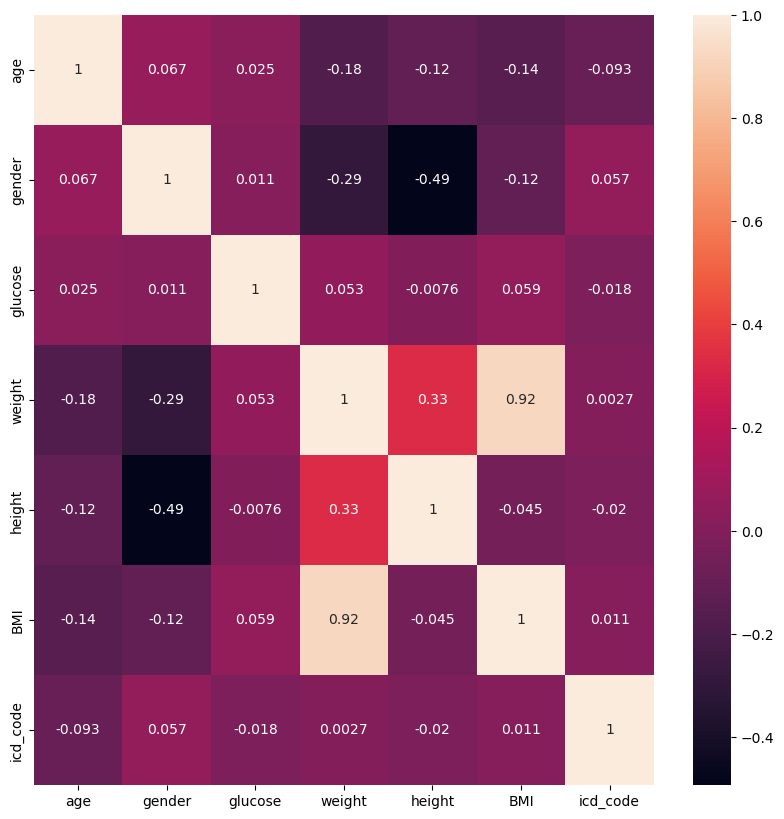

In [13]:
fig=plt.subplots(figsize=(10,10))
ht=df_final.corr()
sns.heatmap(ht,annot=True)
plt.show()

In [14]:
df_final[['glucose','icd_code']]
df_final.icd_code.value_counts()

# df_abnormal = df_final.loc[(df_final.SBP >= 130) | (df_final.DBP >= 80), :]
# df_abnormal.icd_code.value_counts()

0    52449
1      301
Name: icd_code, dtype: int64

In [15]:
df_abnormal=df_final.loc[(df_final.glucose>=100),:]
df_abnormal.icd_code.value_counts()

0    42071
1      201
Name: icd_code, dtype: int64

In [16]:
df_abnormal_only=df_abnormal.loc[df_abnormal.icd_code==1,:]
df_abnormal_only.reset_index(drop=True,inplace=True)
df_abnormal_only

,age,gender,glucose,weight,height,BMI,icd_code
0,64,1,135.0,55.0,163.000000,20.70,1
1,41,1,120.0,71.3,157.000000,28.93,1
2,67,0,130.0,91.2,180.000000,28.15,1
3,43,0,140.0,78.5,173.000000,26.23,1
4,69,1,181.0,80.7,163.000000,30.37,1
...,...,...,...,...,...,...,...
196,86,1,122.0,62.0,159.000000,24.52,1
197,32,1,147.0,82.0,175.000000,26.78,1
198,30,0,154.0,64.0,175.000000,20.90,1
199,35,1,197.0,55.0,163.000000,20.70,1


In [17]:
df_normal=df_final.loc[(df_final.glucose<100),:]
df_normal.icd_code.value_counts()

# df_normal=df_final.loc[((df_final.SBP < 130) | (df_final.DBP < 80)),:]
# df_normal.icd_code.value_counts()

0    10378
1      100
Name: icd_code, dtype: int64

In [18]:
df_normal_only=df_normal.loc[df_normal.icd_code==0,:]
df_normal_only.reset_index(drop=True,inplace=True)
df_normal_only

,age,gender,glucose,weight,height,BMI,icd_code
0,53,1,98.0,96.0,157.000000,38.95,0
1,80,1,95.0,53.0,168.824223,18.60,0
2,21,0,88.0,82.0,178.000000,25.88,0
3,80,1,99.0,43.0,150.000000,19.11,0
4,24,0,90.0,67.0,168.824223,23.51,0
...,...,...,...,...,...,...,...
10373,52,1,70.0,85.0,160.000000,33.20,0
10374,47,0,87.0,70.0,157.000000,28.40,0
10375,52,1,93.0,49.4,157.000000,20.04,0
10376,42,0,67.0,68.8,165.000000,25.27,0


In [19]:
from sklearn.utils import shuffle
df=pd.concat([df_abnormal_only,df_normal_only])
df_shuffled=shuffle(df)
df_shuffled=df_shuffled.reset_index(drop=True)
df_shuffled

,age,gender,glucose,weight,height,BMI,icd_code
0,83,0,98.0,60.5,168.824223,21.23,0
1,51,1,98.0,78.7,170.000000,27.23,0
2,62,0,95.0,102.7,180.000000,31.70,0
3,73,0,90.0,86.0,178.000000,27.14,0
4,76,1,208.0,74.9,157.000000,30.39,1
...,...,...,...,...,...,...,...
10574,65,0,86.0,89.0,168.000000,31.53,0
10575,67,0,83.0,54.0,168.824223,18.95,0
10576,40,1,75.0,94.0,168.000000,33.30,0
10577,74,0,78.0,50.2,178.000000,15.84,0


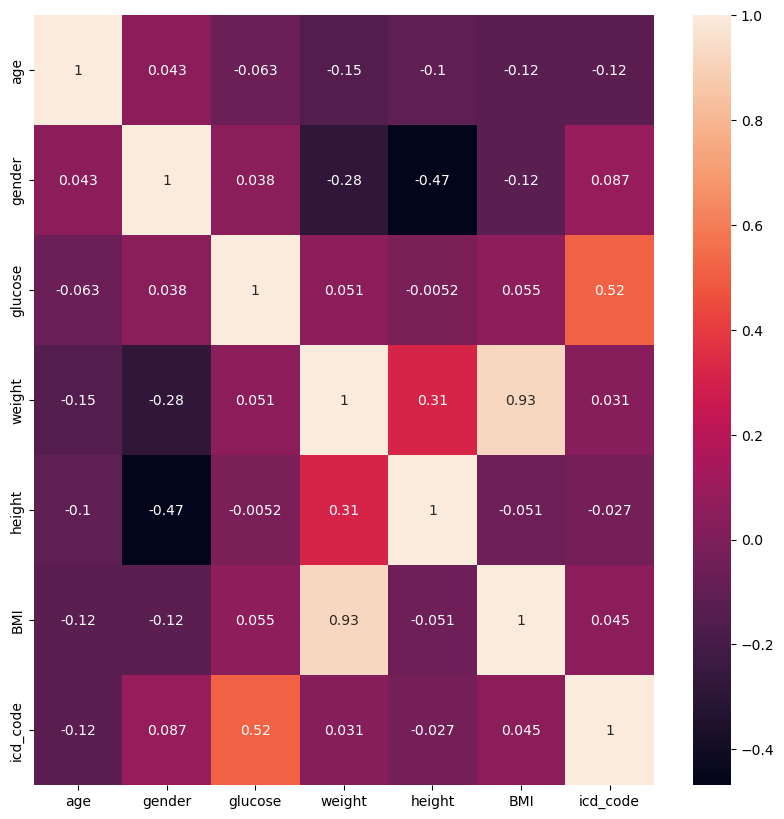

In [20]:
fig=plt.subplots(figsize=(10,10))
ht=df_shuffled.corr()
sns.heatmap(ht,annot=True)
plt.show()

In [21]:
df_shuffled.to_csv('df_final_version.csv',index=False)
df_shuffled=pd.read_csv('df_final_version.csv')

In [22]:
# Y=df_shuffled[['icd_code']].values
# X=df_shuffled[['age','gender','weight','glucose','height','BMI']].values

# scaler=MinMaxScaler()
# scaler.fit(X)
# X_scaled=scaler.transform(X)
# Y_onehot=np_utils.to_categorical(Y)
# X_train,X_test,y_train,y_test=train_test_split(X_scaled,Y_onehot,test_size=0.2,random_state=0)


In [23]:
# def dnn_model():
#     model=Sequential()
#     model.add(Dense(32,input_shape=(6,),activation='relu'))
#     model.add(Dense(32,activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dense(64,activation='relu'))
#     model.add(Dense(64,activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.4))
#     model.add(Dense(16,activation='relu'))
#     model.add(Dense(16,activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.4))
#     model.add(Dense(8,activation='relu'))
#     model.add(Dense(8,activation='relu'))
#     model.add(BatchNormalization())
#     model.add(Flatten())
#     model.add(Dropout(0.4))
#     model.add(Dense(2,activation='softmax'))
#     return model
# dnn=dnn_model()
# early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=2)
# dnn.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
# history=dnn.fit(X_train,y_train,batch_size=64,epochs=200,shuffle=False,verbose=1,validation_data=(X_test,y_test),callbacks=[early_stopping])

In [24]:
# score=dnn.evaluate(X_test,y_test)
# print('Test loss:',score[0])
# print('Test accuracy:',score[1])
# #plt.plot(history.epoch,history.history.get('val_accuracy'),c='g',label='validation acc')
# #plt.plot(history.epoch,history.history.get('accuracy'),c='b',label='train acc')
# plt.legend()

In [25]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score,f1_score,precision_score
# pred=np.argmax(dnn.predict(X_test),axis=1)
# y_t=np.argmax(y_test,axis=1)
# print('precision score:',precision_score(y_t,pred))
# print('f1 score:',f1_score(y_t,pred))
# print('recall score:',recall_score(y_t,pred))
# print('accuracy score:',accuracy_score(y_t,pred))

2023-11-22 13:57:15.997723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-22 13:57:16.025936: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-11-22 13:57:16.026004: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-11-22 13:57:16.027260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

Epoch 1/200
281/281 [==============================] - 3s 8ms/step - loss: 0.1138 - accuracy: 0.9815 - val_loss: 0.1067 - val_accuracy: 0.9767
Epoch 2/200
281/281 [==============================] - 2s 7ms/step - loss: 0.0902 - accuracy: 0.9818 - val_loss: 0.0994 - val_accuracy: 0.9767
Epoch 3/200
281/281 [==============================] - 2s 8ms/step - loss: 0.0820 - accuracy: 0.9818 - val_loss: 0.0911 - val_accuracy: 0.9767
Epoch 4/200
281/281 [==============================] - 2s 9ms/step - loss: 0.0739 - accuracy: 0.9822 - val_loss: 0.0822 - val_accuracy: 0.9773
Epoch 5/200
281/281 [==============================] - 2s 9ms/step - loss: 0.0642 - accuracy: 0.9839 - val_loss: 0.0705 - val_accuracy: 0.9779
Epoch 6/200
281/281 [==============================] - 2s 8ms/step - loss: 0.0567 - accuracy: 0.9845 - val_loss: 0.0589 - val_accuracy: 0.9824
Epoch 7/200
281/281 [==============================] - 2s 8ms/step - loss: 0.0482 - accuracy: 0.9865 - val_loss: 0.0510 - val_accuracy: 0.9842

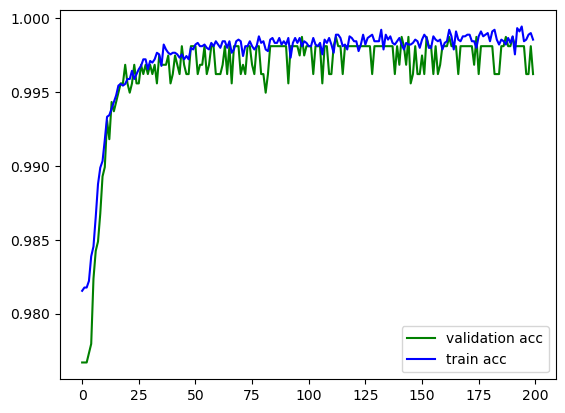

In [26]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

Y=df_shuffled[['icd_code']].values
X=df_shuffled[['glucose','age','gender','weight','BMI','height']].values

scaler=MinMaxScaler()
scaler.fit(X)
X_scaled=scaler.transform(X)
X_scaled=np.expand_dims(X_scaled,axis=2) 
joblib.dump(scaler, '/Data4TB/zhan/mimiciv_hypertension/scaler.pkl') 

Y_onehot=np_utils.to_categorical(Y)
X_train,X_test,y_train,y_test=train_test_split(X_scaled,Y_onehot,test_size=0.15,random_state=0)
def cnn_model():
    model=Sequential()
    model.add(Conv1D(32,3,input_shape=(6,1),activation='tanh',padding='same'))
    model.add(MaxPooling1D(3,padding='same'))
    model.add(SpatialDropout1D(0.3))
    model.add(Conv1D(64,3,activation='tanh',padding='same'))
    model.add(MaxPooling1D(3,padding='same'))
    model.add(SpatialDropout1D(0.3))
    model.add(Flatten())
    model.add(Dense(2,activation='softmax'))
    # print(model.summary())
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model
cnn=cnn_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=2)
# estimator=KerasClassifier(build_fn=cnn_model,epochs=200,batch_size=16,verbose=1,validation_data=(X_test,y_test))
history=cnn.fit(X_train,y_train,epochs=200,batch_size=32,shuffle=False,verbose=1,validation_data=(X_test,y_test),callbacks=[early_stopping])
score=cnn.evaluate(X_test,y_test)
print('Test loss:',score[0])
print('Test accuracy:',score[1])
plt.plot(history.epoch,history.history.get('val_accuracy'),c='g',label='validation acc')
plt.plot(history.epoch,history.history.get('accuracy'),c='b',label='train acc')
plt.legend()

In [27]:
pred=np.argmax(cnn.predict(X_test),axis=1)
y_t=np.argmax(y_test,axis=1)
print('precision score:',precision_score(y_t,pred))
print('f1 score:',f1_score(y_t,pred))
print('recall score:',recall_score(y_t,pred))
print('accuracy score:',accuracy_score(y_t,pred))

50/50 [==============================] - 0s 4ms/step
precision score: 1.0
f1 score: 0.911764705882353
recall score: 0.8378378378378378
accuracy score: 0.996219281663516


In [28]:
cnn.save("hypertension.h5")